# Linear MNIST Classifier

### Imports

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Load Test Data (Legacy Method)

In [3]:
mnist = input_data.read_data_sets("MNIST Data/", one_hot=True, validation_size=0)
print(f"Training set size: {mnist.train.num_examples}")
print(f"Test set size: {mnist.test.num_examples}")
print(f"Validation set size: {mnist.validation.num_examples}")

Extracting MNIST Data/train-images-idx3-ubyte.gz
Extracting MNIST Data/train-labels-idx1-ubyte.gz
Extracting MNIST Data/t10k-images-idx3-ubyte.gz
Extracting MNIST Data/t10k-labels-idx1-ubyte.gz
Training set size: 60000
Test set size: 10000
Validation set size: 0


### Display Sample Images

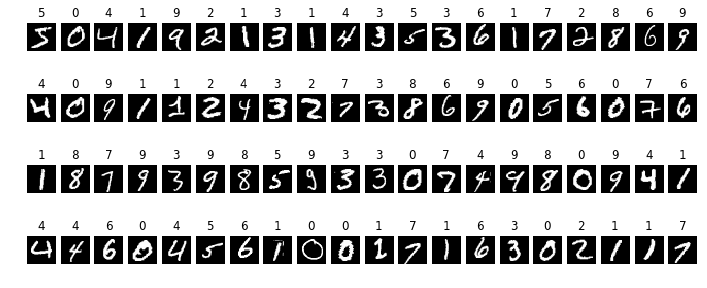

In [4]:
rows = 4
cols = 20
f, axes = plt.subplots(rows, cols, figsize=(12,5)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        axes[i, j].imshow(mnist.train.images[index].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f"{mnist.train.labels[index].argmax()}")
        axes[i, j].axis('off')

### Define Graph

In [5]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [6]:
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='image') # Nx784
    y = tf.placeholder(tf.float32, shape=[None, 10], name='label')  # Nx10
with tf.name_scope('LinearModel'):
    W = tf.Variable(tf.zeros([784, 10]), name='weights')  # 784x10
    b = tf.Variable(tf.zeros([10]), name='bias') # 1x10
    y_hat = tf.matmul(x, W) + b # Nx10
    variable_summaries(y_hat)

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat, name='softmax'))
    tf.summary.scalar('loss', loss)
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
summarize_all = tf.summary.merge_all()

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1)), tf.float32)) # % of correct predictions

### Run

In [7]:
start_time = time.time()
init = tf.global_variables_initializer()
num_iterations = 2000
batch_size = 200
log_path = './TBLogs/'
with tf.Session() as sess:
    tbWriter = tf.summary.FileWriter(log_path, sess.graph)
    sess.run(init)    
    for i in range(num_iterations):        
        images, labels = mnist.train.next_batch(batch_size) # Nx784 and Nx10, randomly selected
        _, summary = sess.run([optimizer, summarize_all], feed_dict={x:images, y:labels})
        tbWriter.add_summary(summary, i)
        if (i % 200 == 0) or (i == num_iterations-1):
            l = sess.run(loss, feed_dict={x:images, y:labels})
            end_time = time.time()
            acc = sess.run(accuracy, feed_dict={y:labels, x:images})
            print(f"Step {i} complete after {end_time-start_time:.1f}s, with loss {l:.2f} and training accuracy {acc*100:.1f}%.")
    tbWriter.close()
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.1f}s.")
    # Show accuracy on both data sets
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:mnist.train.images, y:mnist.train.labels})
    print(f"Accuracy on training data: {acc*100:.1f}%.")
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:mnist.test.images, y:mnist.test.labels})
    print(f"Accuracy on test data: {acc*100:.1f}%.")    


Step 0 complete after 3.6s, with loss 1.75 and training accuracy 46.0%.
Step 200 complete after 4.0s, with loss 0.37 and training accuracy 91.0%.
Step 400 complete after 4.4s, with loss 0.23 and training accuracy 93.5%.
Step 600 complete after 4.8s, with loss 0.29 and training accuracy 91.0%.
Step 800 complete after 5.1s, with loss 0.31 and training accuracy 88.5%.
Step 1000 complete after 5.6s, with loss 0.14 and training accuracy 97.0%.
Step 1200 complete after 6.0s, with loss 0.33 and training accuracy 89.5%.
Step 1400 complete after 6.3s, with loss 0.25 and training accuracy 93.5%.
Step 1600 complete after 6.7s, with loss 0.27 and training accuracy 90.0%.
Step 1800 complete after 7.1s, with loss 0.22 and training accuracy 93.5%.
Step 1999 complete after 7.3s, with loss 0.24 and training accuracy 93.5%.
Elapsed time: 7.5s.
Accuracy on training data: 92.4%.
Accuracy on test data: 92.0%.


### Check Prediction on Test Set

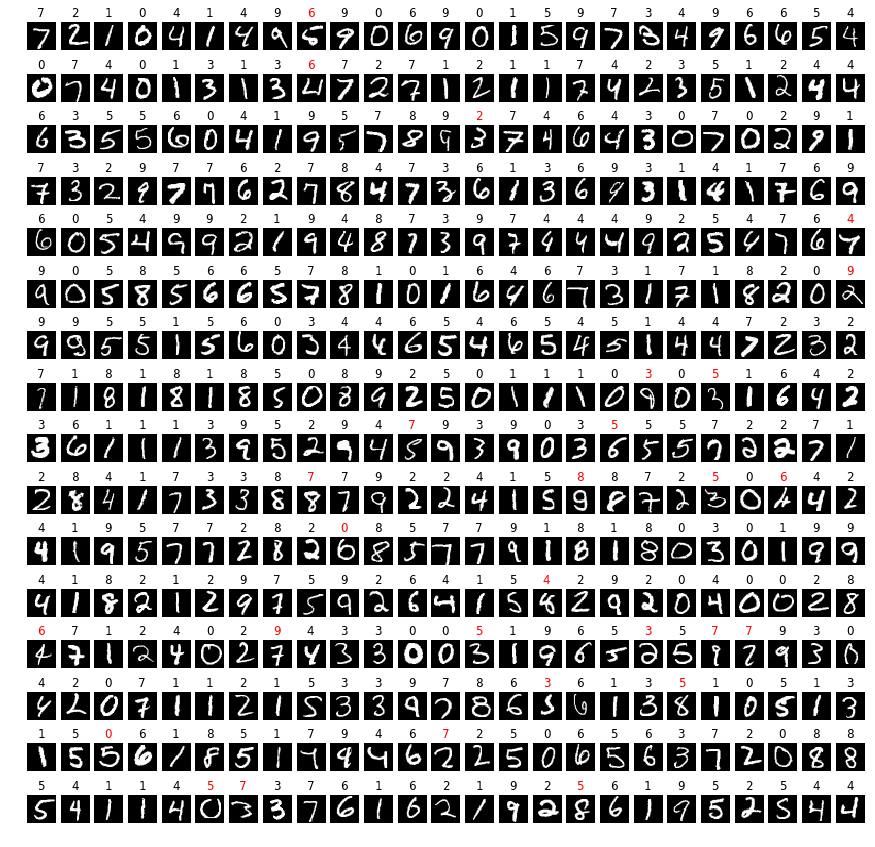

In [8]:
rows, cols = 16, 25
np.set_printoptions(precision=3, suppress=True)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        image = mnist.test.images[index]
        output = np.matmul(image, weights) + bias # score = image * weights + bias
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probalities
        color = 'k' if (probabilities.argmax() == mnist.test.labels[index].argmax()) else 'r'
        axes[i, j].imshow(image.reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{probabilities.argmax()}", color=color)
        axes[i, j].axis('off')

In [9]:
errors = 0
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        image = mnist.test.images[index]
        output = np.matmul(image, weights) + bias 
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probalities
        label = mnist.test.labels[index].argmax()
        if (probabilities.argmax() != label):
            print(f"Digit #{index} is {label} but predicted as {output.argmax()}. Probabilities:")
            print(probabilities)
            errors += 1
print(f"{errors} error(s) out of {rows*cols} ({errors*100/rows/cols:.1f}%).")

Digit #8 is 5 but predicted as 6. Probabilities:
[0.    0.    0.    0.    0.001 0.001 0.997 0.    0.    0.   ]
Digit #33 is 4 but predicted as 6. Probabilities:
[0.283 0.    0.01  0.    0.036 0.162 0.505 0.    0.004 0.   ]
Digit #63 is 3 but predicted as 2. Probabilities:
[0.    0.001 0.652 0.313 0.    0.001 0.001 0.    0.03  0.003]
Digit #124 is 7 but predicted as 4. Probabilities:
[0.    0.    0.    0.    0.652 0.    0.    0.171 0.01  0.167]
Digit #149 is 2 but predicted as 9. Probabilities:
[0.    0.011 0.004 0.015 0.04  0.007 0.014 0.002 0.019 0.886]
Digit #193 is 9 but predicted as 3. Probabilities:
[0.    0.    0.003 0.446 0.223 0.02  0.001 0.075 0.022 0.209]
Digit #195 is 3 but predicted as 5. Probabilities:
[0.    0.018 0.07  0.206 0.005 0.489 0.011 0.    0.186 0.014]
Digit #211 is 5 but predicted as 7. Probabilities:
[0.038 0.    0.    0.013 0.003 0.42  0.    0.446 0.013 0.066]
Digit #217 is 6 but predicted as 5. Probabilities:
[0.011 0.    0.001 0.    0.001 0.526 0.441 0.    

### Display Weights

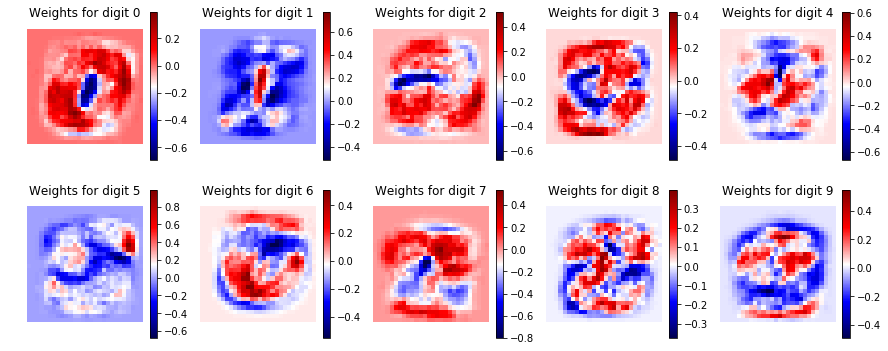

In [37]:
rows, cols = 2, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 6)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        w = weights[:, index].reshape(28,28)
        img = axes[i, j].matshow(w, cmap='seismic', vmin=w.min(), vmax=w.max())
        plt.colorbar(img, ax=axes[i, j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Weights for digit {index}')

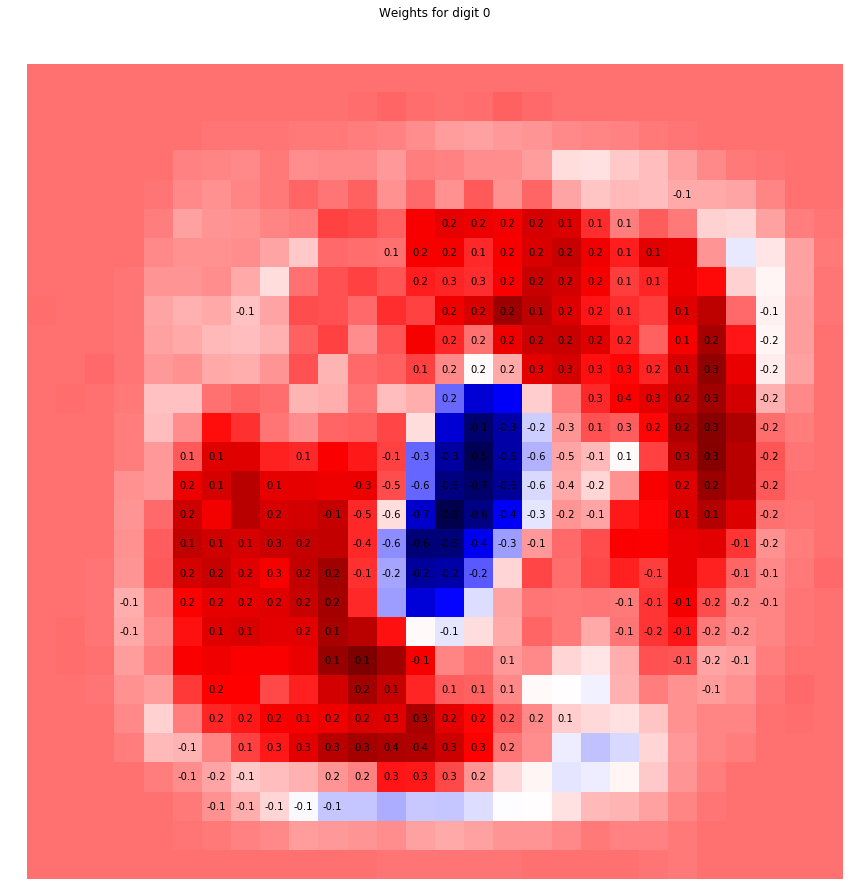

In [44]:
index = 0
w = weights[:, index].reshape(28,28)
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(28):
    for j in range(28):
        if (abs(w[i, j]) > 0.1):
            ax.text(i, j, f'{w[i, j]:.1f}', va='center', ha='center')
img = ax.matshow(w, cmap='seismic')
ax.set_title(f'Weights for digit {index}')
ax.axis('off');